# The difference of MLB teams whether made playoffs or not

Questions:

1) Which factor is the most important factor to decide whether a team made it to post-season or not (highest correlation coefficient)?

2) Once we find out what's the factor, what are the other 3 factos that have the highest correlation coefficient with it?

3) Do teams make it to post-season also have higher salary than teams don't?

4) What are the correlation coefficient of salary and factors found out from question 1 and 2?

After studying the csv files, I decide to use two files: Teams and Salaries. 
Most data I want are in Teams.csv, however, I need team salary column because salary is a critical factor so I will use Salaries.csv to calculate the team salary. Finally, I will add another column called 'intoPost' to indicate whether if this team this year had made it to post-season.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm as nm

%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)

Populating the interactive namespace from numpy and matplotlib


In [2]:
teams = pd.read_csv('Teams.csv')
salaries = pd.read_csv('Salaries.csv')

Sadly, salary only were recorded after 1985, in order to take this variable into account, I decide to use data collected after 1985.

In [3]:
salaries[0:5]

,yearID,teamID,lgID,playerID,salary
0,1985,ATL,NL,barkele01,870000
1,1985,ATL,NL,bedrost01,550000
2,1985,ATL,NL,benedbr01,545000
3,1985,ATL,NL,campri01,633333
4,1985,ATL,NL,ceronri01,625000


Checking how many null value, I think it's not a coincident that DivWin, LgWin and WSWin all have 28 missing value.

In [4]:
teams1985 = teams.loc[teams['yearID'] >= 1985, : ]
teams1985.isnull().sum()

yearID              0
lgID                0
teamID              0
franchID            0
divID               0
Rank                0
G                   0
Ghome               0
W                   0
L                   0
DivWin             28
WCWin             264
LgWin              28
WSWin              28
R                   0
AB                  0
H                   0
2B                  0
3B                  0
HR                  0
BB                  0
SO                  0
SB                  0
CS                  0
HBP               408
SF                408
RA                  0
ER                  0
ERA                 0
CG                  0
SHO                 0
SV                  0
IPouts              0
HA                  0
HRA                 0
BBA                 0
SOA                 0
E                   0
DP                  0
FP                  0
name                0
park                0
attendance          0
BPF                 0
PPF                 0
teamIDBR  

As a result of a players’ strike, the MLB season ended prematurely on August 11, 1994. No postseason (including the World Series) in 1994 was played. (https://en.wikipedia.org/wiki/1994_Major_League_Baseball_season) let's make sure if that's true in our data.

The reason WCWin has 264 NAs is because MLB didn't add it to post-season games before 2012. But similar format had been used from 1994 to 2011. However, in our dataset, WCWin only were recorded since 1995. (https://en.wikipedia.org/wiki/Major_League_Baseball_wild-card_game)

Finally, in this dataset, after year 2000 only HBP and SF are not NaN, so I won't be using this two factors.

In [5]:
print all(teams1985.loc[teams1985['DivWin'].isnull() == True, :].index == teams1985.loc[teams1985['yearID'] == 1994, :].index)
print all(teams1985.loc[teams1985['WCWin'].isnull() == True, :].index == teams1985.loc[teams1985['yearID'] < 1995, :].index)
print all(teams1985.loc[teams1985['HBP'].isnull() == True, :].index == teams1985.loc[teams1985['yearID'] < 2000, :].index)
print all(teams1985.loc[teams1985['SF'].isnull() == True, :].index == teams1985.loc[teams1985['yearID'] < 2000, :].index)

True
True
True
True


Remove the data of year 1994 from our dataframe.

In [6]:
teams1985 = teams1985.loc[teams1985['yearID'] != 1994, :]
salaries = salaries.loc[salaries['yearID'] != 1994, :]

One thing raise my suspicion, if I groupby(['yearID', 'teamID', 'lgID]).sum(), then there will have two more rows!!

In [7]:
salariesSum = salaries.groupby(['yearID', 'teamID'], as_index= False).sum()
tempA = salaries.groupby(['yearID', 'teamID']).sum()
tempB = salaries.groupby(['yearID', 'teamID', 'lgID']).sum()
print tempA.shape
print tempB.shape

(860, 1)
(862, 1)


After carefully checking the data, I found out 'yearID = 2014', 'teamID = CLE' where all lgID = AL except one record.
The other one is yearID = 2015, teamID = ARI, where all lgID = NL except one record.
I use the following code to find out where are the mistakes, and since it only has two mistakes, 
I simply run this code twice and hand correcting it.

for i in range(len(tempA)):
    if tempA.iloc[i].item() != tempB.iloc[i].item():
        print '\n tempA: ', tempA.iloc[i]
        print 'tempB: ', tempB.iloc[i]    

In [8]:
# Correcting the mistake.
salaries.set_value(24147, 'lgID', 'AL')
salaries.set_value(24781, 'lgID', 'NL')

# After done, you can see that the row numbers are the same.
salariesSum = salaries.groupby(['yearID', 'teamID'], as_index= False).sum()
tempA = salaries.groupby(['yearID', 'teamID']).sum()
tempB = salaries.groupby(['yearID', 'teamID', 'lgID']).sum()
print tempA.shape
print tempB.shape

(860, 1)
(860, 1)


Let's check how our dataframe looks like. It seems we can remove some unwanted columns like name, etc.

In [9]:
data = teams1985.merge(salariesSum, on = ['yearID', 'teamID'], how = 'inner')
with pd.option_context('display.max_rows', 5,'display.max_columns', None):
    print data

     yearID lgID teamID franchID divID  Rank    G  Ghome   W   L DivWin WCWin  \
0      1985   NL    ATL      ATL     W     5  162   81.0  66  96      N   NaN   
1      1985   AL    BAL      BAL     E     4  161   81.0  83  78      N   NaN   
..      ...  ...    ...      ...   ...   ...  ...    ...  ..  ..    ...   ...   
858    2015   NL    SDN      SDP     W     4  162   81.0  74  88      N     N   
859    2015   NL    COL      COL     W     5  162   81.0  68  94      N     N   

    LgWin WSWin    R    AB     H   2B  3B   HR   BB      SO    SB    CS   HBP  \
0       N     N  632  5526  1359  213  28  126  553   849.0  72.0  52.0   NaN   
1       N     N  818  5517  1451  234  22  214  604   908.0  69.0  43.0   NaN   
..    ...   ...  ...   ...   ...  ...  ..  ...  ...     ...   ...   ...   ...   
858     N     N  650  5457  1324  260  36  148  426  1327.0  82.0  29.0  40.0   
859     N     N  737  5572  1479  274  49  186  388  1283.0  97.0  43.0  33.0   

       SF   RA   ER   ERA 

In [10]:
# Remove unwanted columns.
try:
    del data['teamIDBR']
    del data['teamIDlahman45']
    del data['teamIDretro']
    del data['park']
    del data['name']
except:
    pass

Now I add column 'intoPost' to our dataframe, intoPost = 1 means this year this team made it to post-season, intoPost = 0 means did not make it to post-seasons. I define a function, then call this function using df.apply(axis = 1).

In [11]:
# 1 means the team made it to post-seasons
def intoPost(row):
    if row['DivWin'] == 'Y' or row['WCWin'] == 'Y':
        return 1
    else:
        return 0

In [12]:
data['intoPost'] = data.apply(intoPost, axis = 1)

Also, becaue the salary increased over time, so I normalized it to make another column: salaryN

In [13]:
temp = data.groupby('yearID').transform(lambda x: (x - x.mean()) / x.std())
data['salaryN'] = temp['salary']

Using intoPost as index, I group the data and calculate its column mean. Judging by the data, I think columns: W, R, HR, SHO and salary look like critical factors.

In [14]:
with pd.option_context('display.max_rows', None,'display.max_columns', None):
    print data.groupby('intoPost').mean()

               yearID      Rank           G      Ghome          W          L  \
intoPost                                                                       
0         2000.052469  3.844136  161.365741  80.649691  76.310185  85.010802   
1         2002.603774  1.245283  161.306604  80.688679  93.929245  67.334906   

                   R           AB            H          2B        3B  \
intoPost                                                               
0         718.044753  5514.206790  1431.998457  274.317901  31.20679   
1         789.349057  5527.575472  1476.108491  287.650943  31.29717   

                  HR          BB           SO          SB         CS  \
intoPost                                                               
0         152.864198  519.081790  1045.609568  105.679012  46.538580   
1         175.122642  567.424528  1052.084906  105.849057  42.608491   

                HBP         SF          RA          ER       ERA        CG  \
intoPost               

Redo what last code did, but this time I divided each cells to column means of 'not intoPost', so I can get percentage of their difference. Based on this data, W has 23% difference, HR 14%, SHO 33% and salary has 48% difference between intoPost and not intoPost.

In [15]:
temp = data.groupby(['intoPost']).mean()
with pd.option_context('display.max_rows', None,'display.max_columns', None):
    print temp.div(temp.iloc[0])

            yearID      Rank         G     Ghome         W         L  \
intoPost                                                               
0         1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1         1.001276  0.323944  0.999634  1.000483  1.230887  0.792075   

                 R        AB         H        2B        3B        HR  \
intoPost                                                               
0         1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1         1.099303  1.002424  1.030803  1.048604  1.002896  1.145609   

                BB        SO        SB        CS       HBP        SF  \
intoPost                                                               
0         1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1         1.093131  1.006193  1.001609  0.915552  1.072605  1.091632   

                RA        ER       ERA        CG       SHO        SV  \
intoPost                                                     

# Question 1 answered: W

Calculating correlation coefficient of intoPost and other columns. From result we can see, W has the highest correlation coefficient with intoPost, L has the smallest correlation coefficient with intoPost. This answers my first question, W is the most important factor to decide if a team made it to post-seasons. 

Although, if I use absolutely value, then correlation coefficient of L and intoPost is slightly higher than W and intoPost. However, W and L are like two sides of a coin, so I am going to use W instead of L to answer question 2.

In [16]:
print data.columns

corList = []

for col in [u'G', u'Ghome', u'W', u'L', u'R', u'AB', u'H', u'2B', u'3B', u'HR', u'BB', u'SO', u'SB', u'CS', u'HBP',
       u'SF', u'RA', u'ER', u'ERA', u'CG', u'SHO', u'SV', u'IPouts', u'HA', u'HRA', u'BBA', u'SOA', u'E',
        u'DP', u'FP', u'attendance', u'BPF', u'PPF', u'salary', u'intoPost', u'salaryN']:
    corList.append([col, np.corrcoef(data['intoPost'], data[col])[0, 1]])
corDF = pd.DataFrame(corList, columns= ['col', 'cor'])
corDF.sort_values(by = 'cor', ascending= False)

Index([u'yearID', u'lgID', u'teamID', u'franchID', u'divID', u'Rank', u'G',
       u'Ghome', u'W', u'L', u'DivWin', u'WCWin', u'LgWin', u'WSWin', u'R',
       u'AB', u'H', u'2B', u'3B', u'HR', u'BB', u'SO', u'SB', u'CS', u'HBP',
       u'SF', u'RA', u'ER', u'ERA', u'CG', u'SHO', u'SV', u'IPouts', u'HA',
       u'HRA', u'BBA', u'SOA', u'E', u'DP', u'FP', u'attendance', u'BPF',
       u'PPF', u'salary', u'intoPost', u'salaryN'],
      dtype='object')


,col,cor
34,intoPost,1.000000
2,W,0.675629
30,attendance,0.401442
21,SV,0.401018
4,R,0.356219
20,SHO,0.304089
10,BB,0.292290
35,salaryN,0.282946
9,HR,0.261676
26,SOA,0.261638


Before answering question 2, let's do some exploratory data analysis by drawing some plot. 

First, histogram of W of intoPost and Not intoPost, I normalized because the frequency of Not intoPost is much more than intoPost. The difference of the two distributions is so much that one doesn't need to perform statistical test to see they are different distribution.

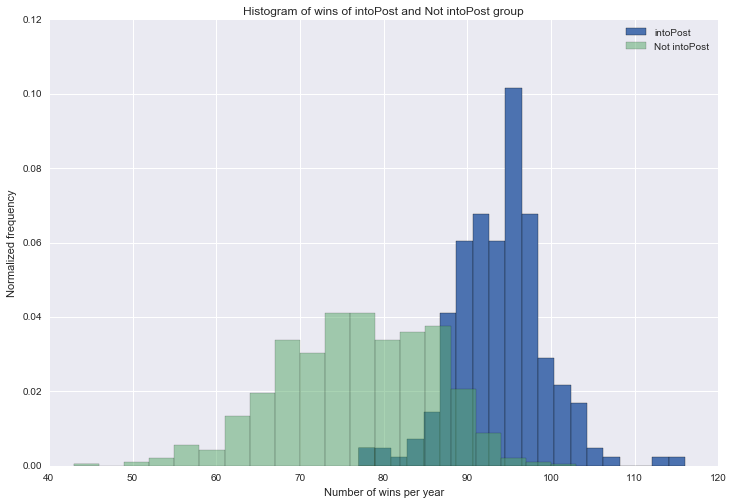

In [17]:
plt.hist(data['W'].loc[(data['intoPost'] == 1), ], alpha = 1, bins = 20, label = 'intoPost', normed = 1)
plt.hist(data['W'].loc[(data['intoPost'] == 0), ], alpha = 0.5, bins = 20, label = 'Not intoPost', normed = 1)
plt.xlabel('Number of wins per year')
plt.ylabel('Normalized frequency')
plt.legend(loc = 'upper right')
plt.title('Histogram of wins of intoPost and Not intoPost group')

Second, box plot. We can see that almost all of W of intoPost are higher than 3rd quartile of W of not intoPost.

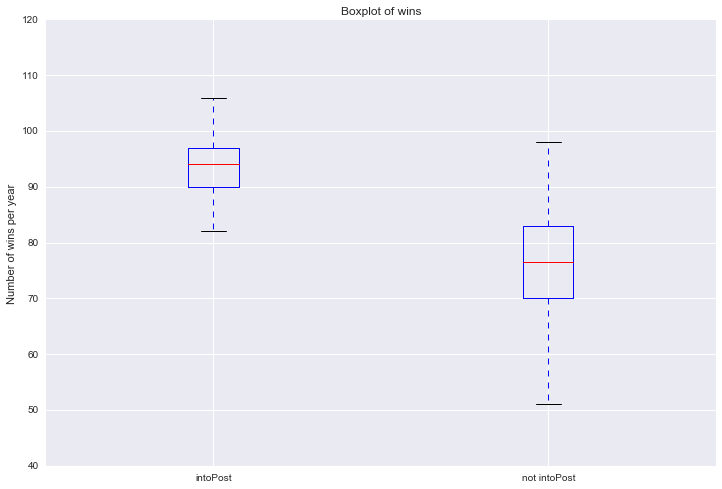

In [18]:
plt.boxplot([data['W'].loc[(data['intoPost'] == 1), ], data['W'].loc[(data['intoPost'] == 0) ]], 
            labels=['intoPost', 'not intoPost'])
plt.title('Boxplot of wins')
plt.ylabel('Number of wins per year')

Third, scatter plot of wins against year, I use orange dot to indicate dots that are belong to the intoPost group and draw a 95-wins-per-year horizontal line. As a result, above the line, most of the dots are orange dots, below the line, most of the dots are black dots. Which tells us that 95 wins per year are a fine line to separate teams made it to post-seasons or not.

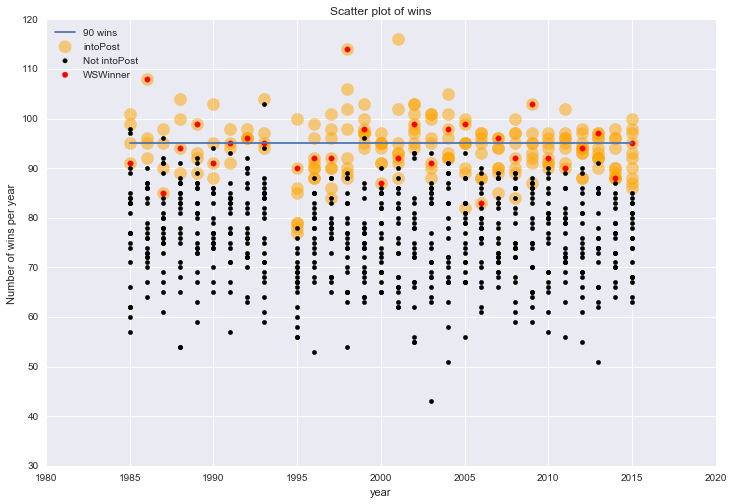

In [19]:
temp = data.loc[data['intoPost'] == 1, :]
xVal = temp['yearID']
yVal = temp['W']
plt.scatter(x = xVal, y = yVal, color = 'orange',s = 150, alpha = 0.5, label = 'intoPost')

temp = data.loc[data['intoPost'] == 0, :]
xVal = temp['yearID']
yVal = temp['W']
plt.scatter(x = xVal, y = yVal, color = 'black', label = 'Not intoPost')

temp = data.loc[data['WSWin'] == 'Y', :]
xVal = temp['yearID']
yVal = temp['W']
plt.scatter(x = xVal, y = yVal, color = 'red', s= 30, label = 'WSWinner')

plt.plot((1985, 2015), (95, 95), label = '90 wins')

plt.xlabel('year')
plt.ylabel('Number of wins per year')
plt.title('Scatter plot of wins')
plt.legend(loc = 'upper left')

As you can see from scatter plot of wins, 95-wins-per-year seems like a good separating line, further calculating its probability can find out that if a team can win 95 games or more per year, it has 95% of chance to make it to post-seasons.

In [20]:
print 'Over 95 wins, the chance of getting post-season: ', 1.0 * len(data[(data['W'] >= 95) & (data['intoPost'] == 1)]) / len(data[data['W'] >= 95])


Over 95 wins, the chance of getting post-season:  0.953703703704


# Question 2 answered: SV, ERA and R

Taking absolutely value of each correlation coefficient, the highest 3 factors are SV, ERA and RA. However, after studying the formula of RA and ER, I found out that they are close to ERA, so I just use ERA and not other two. The next highest correlation coefficient factor is R. So this answer my question 2.

The 3 factors that have the highest correlation coefficient with W are SV, ERA and R.

In [21]:
corList = []

for col in [u'G', u'Ghome', u'W', u'L', u'R', u'AB', u'H', u'2B', u'3B', u'HR', u'BB', u'SO', u'SB', u'CS', u'HBP',
       u'SF', u'RA', u'ER', u'ERA', u'CG', u'SHO', u'SV', u'IPouts', u'HA', u'HRA', u'BBA', u'SOA', u'E',
        u'DP', u'FP', u'attendance', u'BPF', u'PPF', u'salary', u'intoPost', u'salaryN']:
    corList.append([col, np.corrcoef(data['W'], data[col])[0, 1]])
corDF = pd.DataFrame(corList, columns= ['col', 'cor'])
corDF.sort_values(by = 'cor', ascending= False)

,col,cor
2,W,1.000000
34,intoPost,0.675629
21,SV,0.650733
4,R,0.501361
30,attendance,0.496484
20,SHO,0.455194
10,BB,0.401165
6,H,0.362852
35,salaryN,0.353172
22,IPouts,0.329310


Scatter plot of SV and W, according to the plot, more SV leads to more wins.

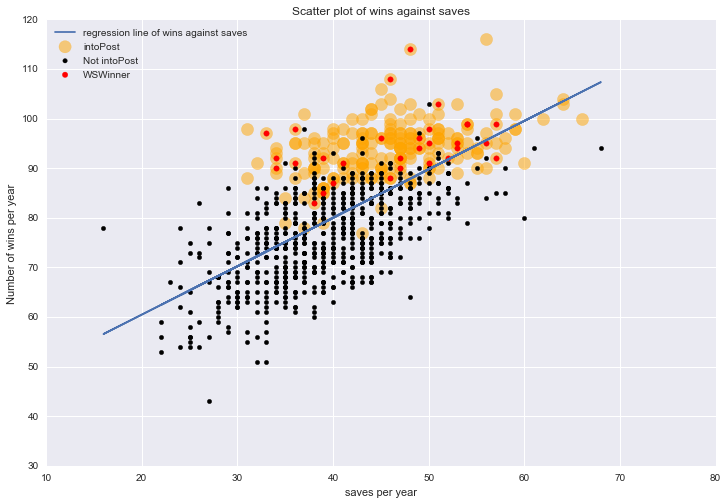

In [22]:
temp = data.loc[data['intoPost'] == 1, :]
xVal = temp['SV']
yVal = temp['W']
plt.scatter(x = xVal, y = yVal, color = 'orange',s = 150, alpha = 0.5, label = 'intoPost')

temp = data.loc[data['intoPost'] == 0, :]
xVal = temp['SV']
yVal = temp['W']
plt.scatter(x = xVal, y = yVal, color = 'black', label = 'Not intoPost')

temp = data.loc[data['WSWin'] == 'Y', :]
xVal = temp['SV']
yVal = temp['W']
plt.scatter(x = xVal, y = yVal, color = 'red', s= 30, label = 'WSWinner')


fit = np.polyfit(x= data['SV'], y= data['W'], deg= 1)
plt.plot(data['SV'], fit[0]*data['SV'] + fit[1], label = 'regression line of wins against saves')


plt.xlabel('saves per year')
plt.ylabel('Number of wins per year')
plt.title('Scatter plot of wins against saves')
plt.legend(loc = 'upper left')

Scatter plot of ERA and W, according to the plot, less ERA leads to more wins.

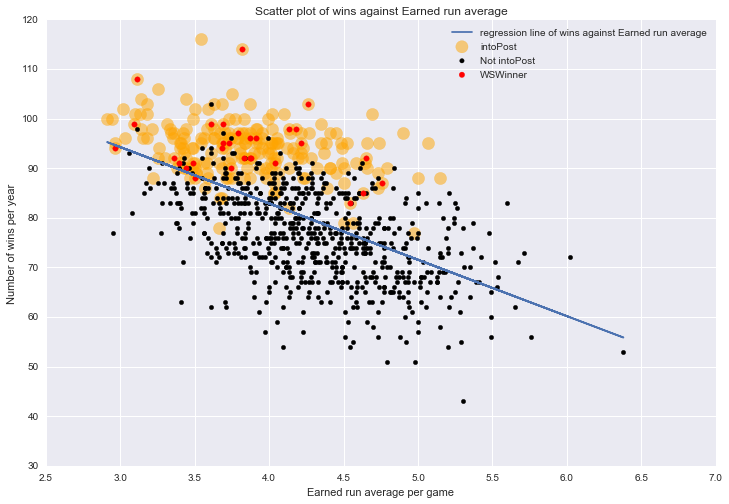

In [23]:
temp = data.loc[data['intoPost'] == 1, :]
xVal = temp['ERA']
yVal = temp['W']
plt.scatter(x = xVal, y = yVal, color = 'orange',s = 150, alpha = 0.5, label = 'intoPost')

temp = data.loc[data['intoPost'] == 0, :]
xVal = temp['ERA']
yVal = temp['W']
plt.scatter(x = xVal, y = yVal, color = 'black', label = 'Not intoPost')

temp = data.loc[data['WSWin'] == 'Y', :]
xVal = temp['ERA']
yVal = temp['W']
plt.scatter(x = xVal, y = yVal, color = 'red', s= 30, label = 'WSWinner')


fit = np.polyfit(x= data['ERA'], y= data['W'], deg= 1)
plt.plot(data['ERA'], fit[0]*data['ERA'] + fit[1], label = 'regression line of wins against Earned run average')


plt.xlabel('Earned run average per game')
plt.ylabel('Number of wins per year')
plt.title('Scatter plot of wins against Earned run average')
plt.legend(loc = 'upper right')

Scatter plot of R and W, according to the plot, more R leads to more wins.

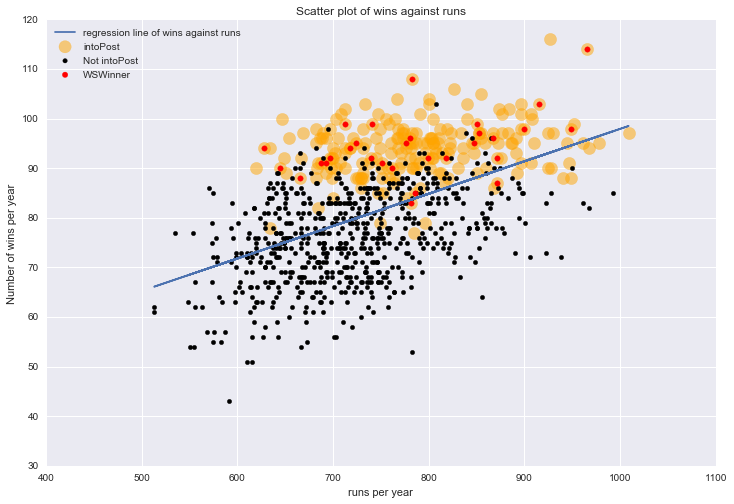

In [24]:
temp = data.loc[data['intoPost'] == 1, :]
xVal = temp['R']
yVal = temp['W']
plt.scatter(x = xVal, y = yVal, color = 'orange',s = 150, alpha = 0.5, label = 'intoPost')

temp = data.loc[data['intoPost'] == 0, :]
xVal = temp['R']
yVal = temp['W']
plt.scatter(x = xVal, y = yVal, color = 'black', label = 'Not intoPost')

temp = data.loc[data['WSWin'] == 'Y', :]
xVal = temp['R']
yVal = temp['W']
plt.scatter(x = xVal, y = yVal, color = 'red', s= 30, label = 'WSWinner')


fit = np.polyfit(x= data['R'], y= data['W'], deg= 1)
plt.plot(data['R'], fit[0]*data['R'] + fit[1], label = 'regression line of wins against runs')


plt.xlabel('runs per year')
plt.ylabel('Number of wins per year')
plt.title('Scatter plot of wins against runs')
plt.legend(loc = 'upper left')

# Exploratory data analysis of salary

Scatter plot of salary, which is not very satisfy because salary increase with time, so the dots of year 1985 all squeeze together.

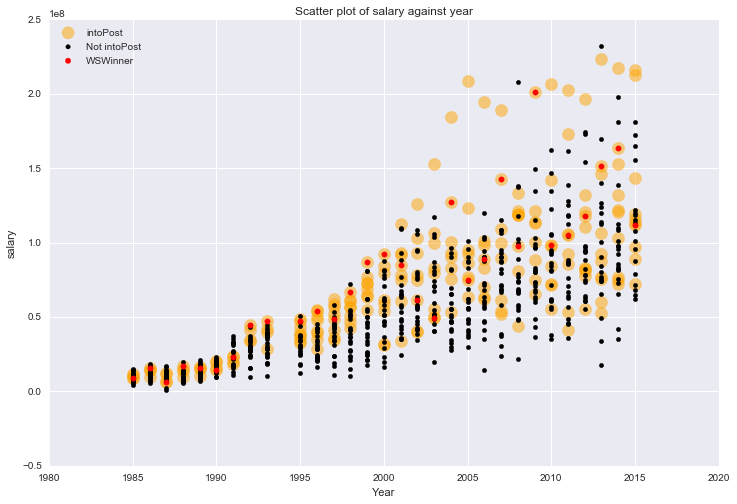

In [25]:
temp = data.loc[data['intoPost'] == 1, :]
xVal = temp['yearID']
yVal = temp['salary']
plt.scatter(x = xVal, y = yVal, color = 'orange',s = 150, alpha = 0.5, label = 'intoPost')

temp = data.loc[data['intoPost'] == 0, :]
xVal = temp['yearID']
yVal = temp['salary']
plt.scatter(x = xVal, y = yVal, color = 'black', label = 'Not intoPost')

temp = data.loc[data['WSWin'] == 'Y', :]
xVal = temp['yearID']
yVal = temp['salary']
plt.scatter(x = xVal, y = yVal, color = 'red', s= 30, label = 'WSWinner')

plt.xlabel('Year')
plt.ylabel('salary')
plt.title('Scatter plot of salary against year')
plt.legend(loc = 'upper left')

Scatter plot of salaryN (normalized salary) against year. From the plot we can clearly observe that

1) You can't just spend money to get into post-seasons, 11 out of 30 years, the richest team didn't get into post-season.

2) Only 6 out of 30 years, the richest team won the world champion.

3) Poorest team never got into post-season. (in 2012, the 2nd poorest team got into post-season, their salary are extremely close)


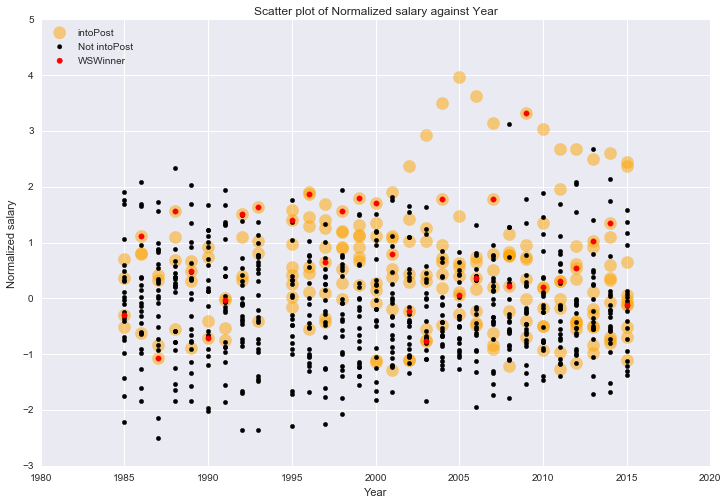

In [26]:
temp = data.loc[data['intoPost'] == 1, :]
xVal = temp['yearID']
yVal = temp['salaryN']
plt.scatter(x = xVal, y = yVal, color = 'orange',s = 150, alpha = 0.5, label = 'intoPost')

temp = data.loc[data['intoPost'] == 0, :]
xVal = temp['yearID']
yVal = temp['salaryN']
plt.scatter(x = xVal, y = yVal, color = 'black', label = 'Not intoPost')

temp = data.loc[data['WSWin'] == 'Y', :]
xVal = temp['yearID']
yVal = temp['salaryN']
plt.scatter(x = xVal, y = yVal, color = 'red', s= 30, label = 'WSWinner')

plt.xlabel('Year')
plt.ylabel('Normalized salary')
plt.title('Scatter plot of Normalized salary against Year')
plt.legend(loc = 'upper left')

In [27]:
data.loc[data['yearID'] == 2012, :].sort_values(by = ['salary', 'intoPost']).iloc[0:5][['yearID', 'salary', 'intoPost']]

,yearID,salary,intoPost
762,2012,55244700,0
759,2012,55372500,1
750,2012,60651000,0
751,2012,60916225,0
761,2012,62951999,0


Histogram of salaryN of intoPost and Not intoPost, normalized. These two distributions look similar, though they are slightly right skewed, and for group intoPost, there are some extermely outlier (you can see that from normalized scatter plot too) but the shape still looks like normal curve.

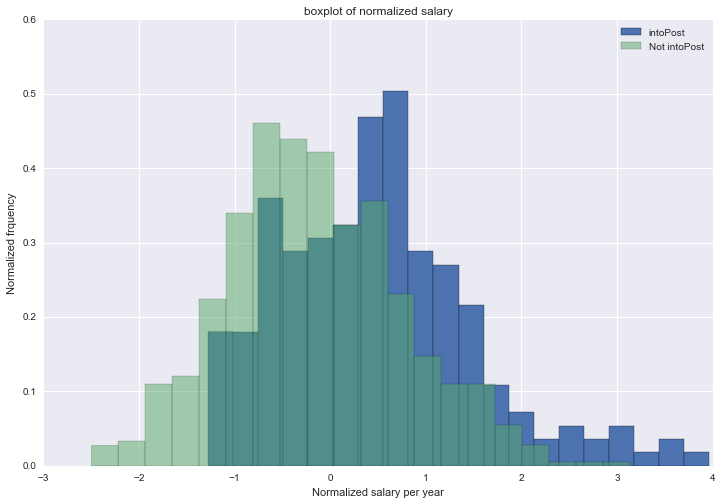

In [28]:
plt.hist(data['salaryN'].loc[(data['intoPost'] == 1), ], alpha = 1, bins = 20, label = 'intoPost', normed = 1)
plt.hist(data['salaryN'].loc[(data['intoPost'] == 0), ], alpha = 0.5, bins = 20, label = 'Not intoPost', normed = 1)

plt.xlabel('Normalized salary per year')
plt.ylabel('Normalized frquency')
plt.title('boxplot of normalized salary')
plt.legend(loc = 'upper right')

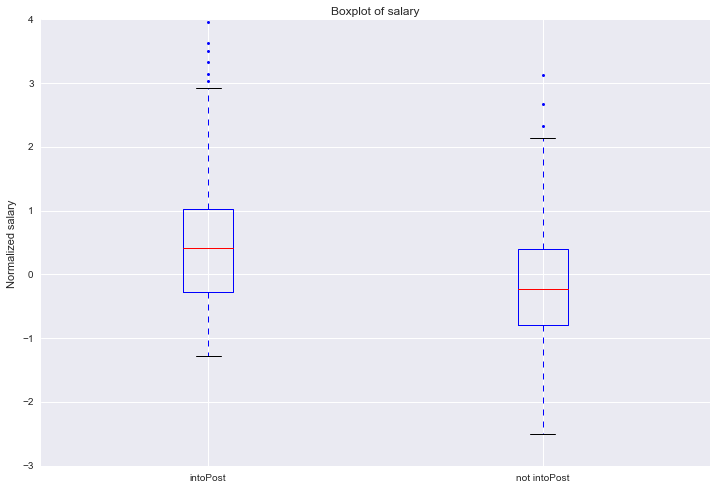

In [29]:
plt.boxplot([data['salaryN'].loc[(data['intoPost'] == 1), ], data['salaryN'].loc[(data['intoPost'] == 0) ]], 
            labels=['intoPost', 'not intoPost'], sym='k.')

plt.title('Boxplot of salary')
plt.ylabel('Normalized salary')

From the looks of the histogram and boxplot, these two groups may come from two different populations, and I believe teams that made it to post-seasons spent more money on salary than teams didn't. I am going to perform statistical test to confirm that.

Because our large sample (over 30), so we will just use z test. $\mu_i$ is the population mean of salaryN of intoPost. $\mu_n$ is the population mean of salaryN of not intoPost.

Null hypothesis is that $\mu_i$ is equal to $\mu_n$. 
Alternative hypothesis is that $\mu_i$ greater than $\mu_n$

I will use significance level = 5%.

$H_0: \mu_i = \mu_n $

$H_1: \mu_i \ge \mu_n$

In [30]:
def zTest(iGroup, nGroup):
    
    # variable start with i means it's statistics from sample intoPost.
    
    iMean = np.mean(iGroup)
    iVar = np.var(iGroup)
    iN = len(iGroup)
    nMean = np.mean(nGroup)
    nVar = np.var(nGroup)
    nN = len(nGroup)
    z = (iMean - nMean)/(sqrt(iVar/iN + nVar/nN))
    print 'z statistcs is: ', z
    print 'p value: ', 1 - nm.cdf(z)

# Question 3 answered: Yes

The p-value is so close to zero. The result of z test confirmed my observation, teams that made it to post-season did spend more money on salary than teams didn't.

In [31]:
zTest(data['salaryN'].loc[(data['intoPost'] == 1)], data['salaryN'].loc[(data['intoPost'] == 0)])

z statistcs is:  8.22609498656
p value:  1.11022302463e-16


# Question 4 answered

Correlation coefficient of salaryN and W, R, SV and ERA are 0.35, 0.24, 0.17 and -0.16.

In [32]:
corList = []

for col in [u'G', u'Ghome', u'W', u'L', u'R', u'AB', u'H', u'2B', u'3B', u'HR', u'BB', u'SO', u'SB', u'CS', u'HBP',
       u'SF', u'RA', u'ER', u'ERA', u'CG', u'SHO', u'SV', u'IPouts', u'HA', u'HRA', u'BBA', u'SOA', u'E',
        u'DP', u'FP', u'attendance', u'BPF', u'PPF', u'salary', u'intoPost', u'salaryN']:
    corList.append([col, np.corrcoef(data['salaryN'], data[col])[0, 1]])
corDF = pd.DataFrame(corList, columns= ['col', 'cor'])
corDF.sort_values(by = 'cor', ascending= False)

,col,cor
35,salaryN,1.000000
30,attendance,0.629550
33,salary,0.539495
2,W,0.353172
34,intoPost,0.282946
4,R,0.242316
10,BB,0.241459
9,HR,0.223156
6,H,0.196693
20,SHO,0.183220


Scatter plot of W against salaryN, the scatter plot shows that they have moderately correlation.

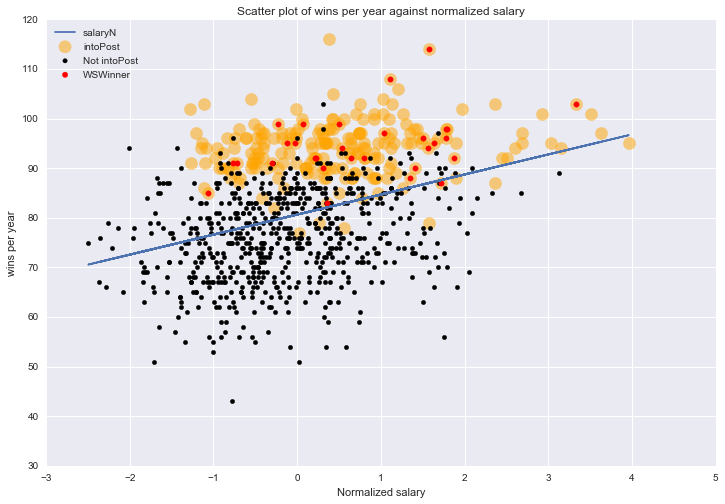

In [33]:
temp = data.loc[data['intoPost'] == 1, :]
xVal = temp['salaryN']
yVal = temp['W']
plt.scatter(x = xVal, y = yVal, color = 'orange',s = 150, alpha = 0.5, label = 'intoPost')

temp = data.loc[data['intoPost'] == 0, :]
xVal = temp['salaryN']
yVal = temp['W']
plt.scatter(x = xVal, y = yVal, color = 'black', label = 'Not intoPost')

temp = data.loc[data['WSWin'] == 'Y', :]
xVal = temp['salaryN']
yVal = temp['W']
plt.scatter(x = xVal, y = yVal, color = 'red', s= 30, label = 'WSWinner')

fit = np.polyfit(x= data['salaryN'], y= data['W'], deg= 1)
plt.plot(data['salaryN'], fit[0]*data['salaryN'] + fit[1])

plt.xlabel('Normalized salary')
plt.ylabel('wins per year')
plt.title('Scatter plot of wins per year against normalized salary')
plt.legend(loc = 'upper left')

Scatter plot of SV, R and ERA against salaryN, the scatter plot shows that they are weakly correlated.

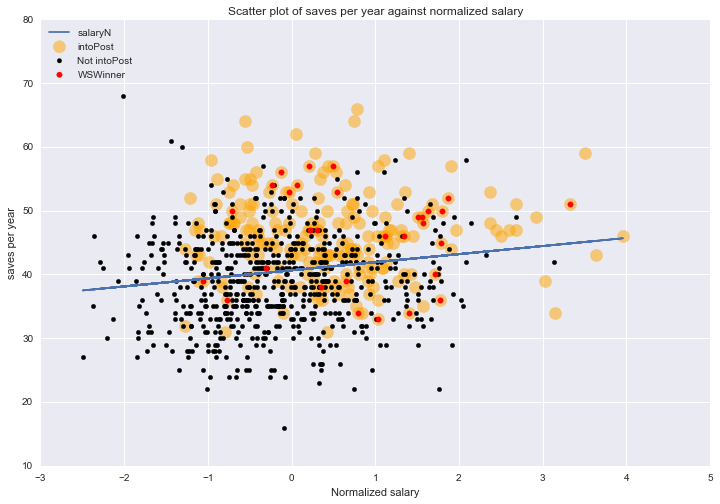

In [34]:
temp = data.loc[data['intoPost'] == 1, :]
xVal = temp['salaryN']
yVal = temp['SV']
plt.scatter(x = xVal, y = yVal, color = 'orange',s = 150, alpha = 0.5, label = 'intoPost')

temp = data.loc[data['intoPost'] == 0, :]
xVal = temp['salaryN']
yVal = temp['SV']
plt.scatter(x = xVal, y = yVal, color = 'black', label = 'Not intoPost')

temp = data.loc[data['WSWin'] == 'Y', :]
xVal = temp['salaryN']
yVal = temp['SV']
plt.scatter(x = xVal, y = yVal, color = 'red', s= 30, label = 'WSWinner')

fit = np.polyfit(x= data['salaryN'], y= data['SV'], deg= 1)
plt.plot(data['salaryN'], fit[0]*data['salaryN'] + fit[1])

plt.xlabel('Normalized salary')
plt.ylabel('saves per year')
plt.title('Scatter plot of saves per year against normalized salary')
plt.legend(loc = 'upper left')

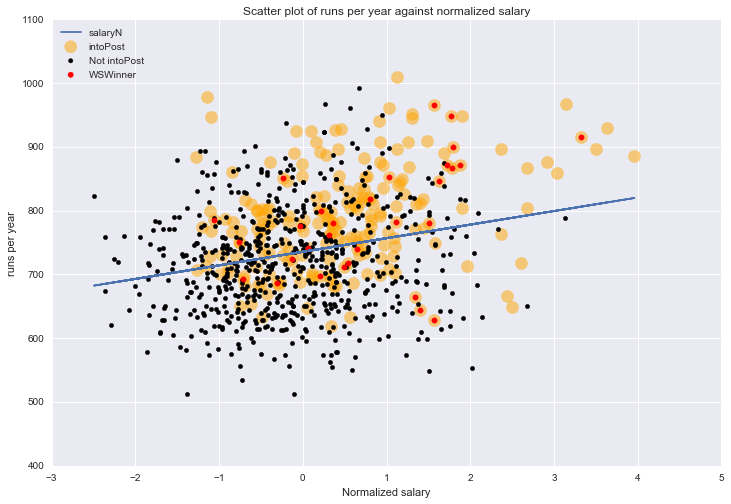

In [35]:
temp = data.loc[data['intoPost'] == 1, :]
xVal = temp['salaryN']
yVal = temp['R']
plt.scatter(x = xVal, y = yVal, color = 'orange',s = 150, alpha = 0.5, label = 'intoPost')

temp = data.loc[data['intoPost'] == 0, :]
xVal = temp['salaryN']
yVal = temp['R']
plt.scatter(x = xVal, y = yVal, color = 'black', label = 'Not intoPost')

temp = data.loc[data['WSWin'] == 'Y', :]
xVal = temp['salaryN']
yVal = temp['R']
plt.scatter(x = xVal, y = yVal, color = 'red', s= 30, label = 'WSWinner')

fit = np.polyfit(x= data['salaryN'], y= data['R'], deg= 1)
plt.plot(data['salaryN'], fit[0]*data['salaryN'] + fit[1])

plt.xlabel('Normalized salary')
plt.ylabel('runs per year')
plt.title('Scatter plot of runs per year against normalized salary')
plt.legend(loc = 'upper left')

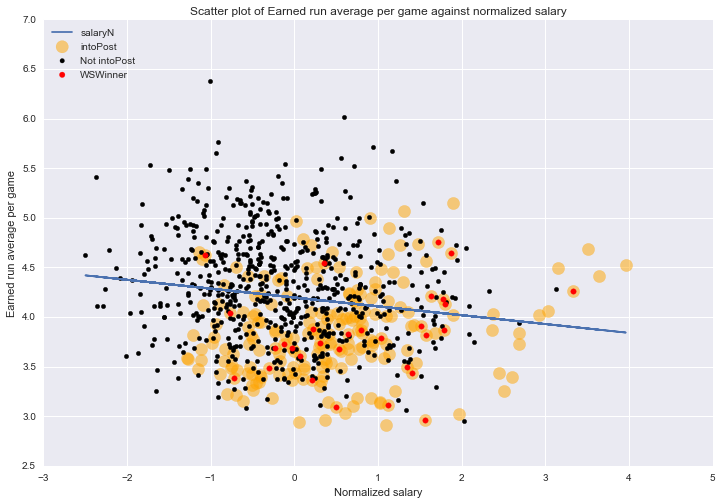

In [36]:
temp = data.loc[data['intoPost'] == 1, :]
xVal = temp['salaryN']
yVal = temp['ERA']
plt.scatter(x = xVal, y = yVal, color = 'orange',s = 150, alpha = 0.5, label = 'intoPost')

temp = data.loc[data['intoPost'] == 0, :]
xVal = temp['salaryN']
yVal = temp['ERA']
plt.scatter(x = xVal, y = yVal, color = 'black', label = 'Not intoPost')

temp = data.loc[data['WSWin'] == 'Y', :]
xVal = temp['salaryN']
yVal = temp['ERA']
plt.scatter(x = xVal, y = yVal, color = 'red', s= 30, label = 'WSWinner')

fit = np.polyfit(x= data['salaryN'], y= data['ERA'], deg= 1)
plt.plot(data['salaryN'], fit[0]*data['salaryN'] + fit[1])

plt.xlabel('Normalized salary')
plt.ylabel('Earned run average per game')
plt.title('Scatter plot of Earned run average per game against normalized salary')
plt.legend(loc = 'upper left')

# Conclusion

From the result, we observed that teams over 95 wins had a 95% of chance made playoffs. We also found out the more SV and R; less ERA leads to more wins. Lastly, we examined the relationship of salary between W, R, SV and ERA and found out higher the salary, higher the W, SV, R, lesser the ERA. However, due to the nature of this study, all the phenomenon we observed are not causation, rather, they are the correlation. 

My initial question was simple enough: how many wins can lead to making playoffs? However, the real million dollar question is how to win a game? As from the result, many variables have moderate to highly correlation with W. The highest one is SV, about 0.15 higher than R. It seems defensive is more important than offensive here. However, this is not causation study. Besides, our dataset does not contain each game statistics, all we have is yearly statistics. Whether defense is more important than offense in a match might be a potential question to study in future. If the answer were true, then teams can invest more money on the defensive side.